Exemplo de uma CNN para reconhecer meses do ano. 

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import progressbar

Carrega a base de dados. Os arquivos train.txt e test.txt contêm os nomes dos arquivos e os labels das imagens que estão dentro do diretório ./data

Note que as imagens precisam ser normalizadas para a entrada da rede neural. Nesse caso, elas estão sendo normalizadas em 64x64. 


---



In [7]:
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

train_file = '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/train.txt'
test_file = '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/test.txt'
# input image dimensions
img_rows, img_cols = 64, 64
num_classes = 12


def load_images(image_paths, convert=False):

  x = []
  y = []

  for image_path in progressbar.progressbar(image_paths):
    path, label = image_path.split(' ')
    path= '/home/nakayama/Documents/Doutorado/Disciplinas/Disciplina_MAchine_Learning/Trabalhos/Trabalho CNN/data/' + path
    
    
    if convert:
      image_pil = Image.open(path).convert('RGB') 
    else:
      image_pil = Image.open(path).convert('L')

    img = np.array(image_pil, dtype=np.uint8)

    x.append(img)
    y.append([int(label)])
    
  x = np.array(x)
  y = np.array(y)

  if np.min(y) != 0: 
    y = y-1

  return x, y
	

def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
  arq = open(train_file, 'r')
  texto = arq.read()
  train_paths = texto.split('\n')
	
  print ('Size : ', size )

  train_paths.remove('') #remove empty lines
  train_paths.sort()

  x_train, y_train = load_images(train_paths, convert)

  arq = open(test_file, 'r')
  texto = arq.read()
  test_paths = texto.split('\n')

  test_paths.remove('') #remove empty lines
  test_paths.sort()
  x_test, y_test = load_images(test_paths, convert)
  
  if resize:
    print ("Resizing images...")
    x_train = resize_data(x_train, size, convert)
    x_test = resize_data(x_test, size, convert)

  if not convert:
    x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
    x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)


  print (np.shape(x_train))
  return (x_train, y_train), (x_test, y_test)

###### Resize data
def resize_data(data, size, convert):

  if convert:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
  else:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1]))

  for i, img in enumerate(data):
    large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
    data_upscaled[i] = large_img

  print (np.shape(data_upscaled))
  return data_upscaled


# rgb
input_shape = (img_rows, img_cols, 3)
(x_train, y_train), (x_test, y_test) = load_dataset(train_file, test_file, resize=True, convert=True, size=(img_rows, img_cols))

### save for the confusion matrix
label = []
for i in range(len(x_test)):
	label.append(y_test[i][0])
	

print ('Normalizing images...')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print ('x_train shape:', x_train.shape)

print (x_train.shape[0], 'train samples')
print (x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)

  3% (60 of 1578) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Size :  (64, 64)


100% (1578 of 1578) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Resizing images...
(1578, 64, 64, 3)
(401, 64, 64, 3)
(1578, 64, 64, 3)
Normalizing images...
x_train shape: (1578, 64, 64, 3)
1578 train samples
401 test samples


Treina a rede neural com três camada de convolução.

---



In [8]:
#batch_size = 100
#epochs = 100

# create cnn model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), 
                    samples_per_epoch=x_train.shape[0],
                    nb_epoch=150, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print ('Test loss:', score[0])
print ('Test accuracy:', score[1])

#print model.predict_classes(x_test) #classes predicted
#print model.predict_proba(x_test) #classes probability

pred = []
y_pred = model.predict_classes(x_test)
for i in range(len(x_test)):
	pred.append(y_pred[i])

print(confusion_matrix(label, pred))


/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/nakayama/anaconda3/envs/Trabalho_CNN/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., steps_per_epoch=12, epochs=150)`


Epoch 1/150
12/12 [==============================] - 11s 942ms/step - loss: 2.5169 - acc: 0.1250 - val_loss: 2.3563 - val_acc: 0.2269
Epoch 2/150
12/12 [==============================] - 8s 692ms/step - loss: 2.3166 - acc: 0.1951 - val_loss: 2.2079 - val_acc: 0.3117
Epoch 3/150
12/12 [==============================] - 9s 753ms/step - loss: 2.1868 - acc: 0.2343 - val_loss: 1.7896 - val_acc: 0.4464
Epoch 4/150
12/12 [==============================] - 11s 908ms/step - loss: 2.0821 - acc: 0.2806 - val_loss: 1.6020 - val_acc: 0.5112
Epoch 5/150
12/12 [==============================] - 10s 859ms/step - loss: 1.9556 - acc: 0.3204 - val_loss: 1.5429 - val_acc: 0.5162
Epoch 6/150
12/12 [==============================] - 9s 765ms/step - loss: 1.9119 - acc: 0.3224 - val_loss: 1.3067 - val_acc: 0.5536
Epoch 7/150
12/12 [==============================] - 11s 885ms/step - loss: 1.8232 - acc: 0.3660 - val_loss: 1.3266 - val_acc: 0.5835
Epoch 8/150
12/12 [==============================] - 11s 936ms/st

12/12 [==============================] - 8s 708ms/step - loss: 0.5239 - acc: 0.8155 - val_loss: 0.2761 - val_acc: 0.9102
Epoch 63/150
12/12 [==============================] - 9s 716ms/step - loss: 0.5158 - acc: 0.8265 - val_loss: 0.3871 - val_acc: 0.8554
Epoch 64/150
12/12 [==============================] - 8s 705ms/step - loss: 0.5273 - acc: 0.8272 - val_loss: 0.3555 - val_acc: 0.8828
Epoch 65/150
12/12 [==============================] - 9s 712ms/step - loss: 0.5201 - acc: 0.8159 - val_loss: 0.3831 - val_acc: 0.8653
Epoch 66/150
12/12 [==============================] - 9s 727ms/step - loss: 0.4688 - acc: 0.8503 - val_loss: 0.2805 - val_acc: 0.9002
Epoch 67/150
12/12 [==============================] - 9s 715ms/step - loss: 0.4819 - acc: 0.8351 - val_loss: 0.2948 - val_acc: 0.9077
Epoch 68/150
12/12 [==============================] - 8s 705ms/step - loss: 0.5100 - acc: 0.8273 - val_loss: 0.3018 - val_acc: 0.9127
Epoch 69/150
12/12 [==============================] - 9s 711ms/step - loss:

12/12 [==============================] - 8s 642ms/step - loss: 0.3065 - acc: 0.8938 - val_loss: 0.1802 - val_acc: 0.9401
Epoch 124/150
12/12 [==============================] - 8s 665ms/step - loss: 0.3244 - acc: 0.8878 - val_loss: 0.1962 - val_acc: 0.9401
Epoch 125/150
12/12 [==============================] - 8s 640ms/step - loss: 0.2842 - acc: 0.9095 - val_loss: 0.2017 - val_acc: 0.9377
Epoch 126/150
12/12 [==============================] - 8s 652ms/step - loss: 0.2884 - acc: 0.9107 - val_loss: 0.2462 - val_acc: 0.9177
Epoch 127/150
12/12 [==============================] - 8s 641ms/step - loss: 0.3364 - acc: 0.8809 - val_loss: 0.2464 - val_acc: 0.9227
Epoch 128/150
12/12 [==============================] - 8s 648ms/step - loss: 0.2996 - acc: 0.8984 - val_loss: 0.1799 - val_acc: 0.9426
Epoch 129/150
12/12 [==============================] - 8s 642ms/step - loss: 0.2827 - acc: 0.9053 - val_loss: 0.2328 - val_acc: 0.9152
Epoch 130/150
12/12 [==============================] - 8s 668ms/step 

Mostra as imagens com erro.

/home/nakayama/anaconda3/envs/TesteML2_a_missao/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets
100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


51
Label: abril  | Prediction: agosto /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0119.jpg


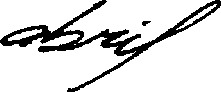

65
Label: setembro  | Prediction: dezembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0251.jpg


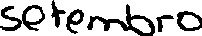

81
Label: setembro  | Prediction: dezembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0269.jpg


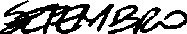

135
Label: novembro  | Prediction: dezembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0331.jpg


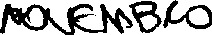

146
Label: dezembro  | Prediction: novembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0342.jpg


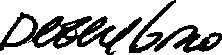

147
Label: dezembro  | Prediction: novembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0343.jpg


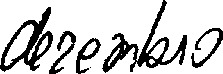

151
Label: dezembro  | Prediction: agosto /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0347.jpg


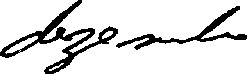

152
Label: dezembro  | Prediction: setembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0348.jpg


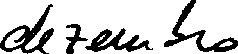

162
Label: dezembro  | Prediction: setembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0358.jpg


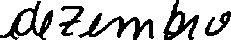

188
Label: janeiro  | Prediction: fevereiro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0386.jpg


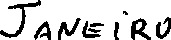

213
Label: fevereiro  | Prediction: novembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0412.jpg


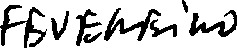

216
Label: fevereiro  | Prediction: janeiro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0416.jpg


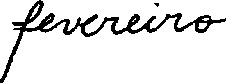

262
Label: abril  | Prediction: junho /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0462.jpg


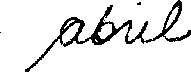

276
Label: abril  | Prediction: janeiro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0476.jpg


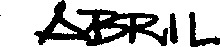

296
Label: maio  | Prediction: abril /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0496.jpg


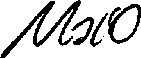

299
Label: maio  | Prediction: abril /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0499.jpg


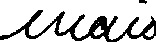

301
Label: maio  | Prediction: abril /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0501.jpg


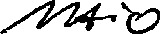

314
Label: maio  | Prediction: abril /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0515.jpg


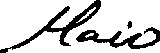

316
Label: junho  | Prediction: julho /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0518.jpg


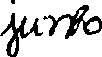

323
Label: junho  | Prediction: janeiro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0525.jpg


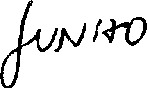

350
Label: julho  | Prediction: junho /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0552.jpg


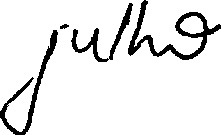

360
Label: julho  | Prediction: outubro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0562.jpg


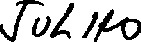

393
Label: dezembro  | Prediction: novembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0701.jpg


394
Label: dezembro  | Prediction: novembro /home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/td0702.jpg


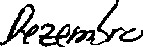

In [5]:
###############################################################################
# Show confusions
###############################################################################
meses = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

from google.colab.patches import cv2_imshow

arq = open(test_file, 'r')
texto = arq.read()
test_paths = texto.split('\n')

test_paths.remove('') #remove empty lines
test_paths.sort()

images =[]
labels = []

for image_path in progressbar.progressbar(test_paths):
  path, label = image_path.split(' ')
  path= '/home/nakayama/Documentos/Doutorado/Disciplinas/disciplina_machine_learning/Trabalhos/CNN/data/' + path
  
  images.append(path)
  labels.append(int(label))
    

for i in range(len(y_pred)):

  ## Erro...
  if (y_pred[i] != labels[i]):
    print (i)
      
    print("Label:", meses[labels[i]], " | Prediction:", meses[y_pred[i]], images[i] )
    im=cv2.imread(images[i])
    cv2_imshow(im)